# Exercise 2

## Fundamentals of Machine Learning

#### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl

#### Version information:
        2020-12-07: v.1.0. First public release. 


In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn import model_selection

## 3 - Data Preparation
We filter the full digits dataset such that only the digits "1" and "7" are left. Of the remaining 361 instances, we split these up into a training and test set with proportions 3 to 2 respectively.

In [2]:
# Import the digits dataset
digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

# Filter out ones and sevens from the dataset.
mask = (target == 1) | (target == 7)
data_filtered   = data[mask,:]
target_filtered = target[mask]

# Create training and test sets.
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_filtered,target_filtered,test_size=0.4,random_state=0)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
X_train.shape[0]/X_test.shape[0]

1.4896551724137932

### 3.1 - Dimension reduction (3 pts)
We use a simple minded approach of looking at the average images of each class and finding two pixels that have the largest difference in the average pixel values. These two pixels should theoretically best characterise and differentiate each class from one another.

[19 60]


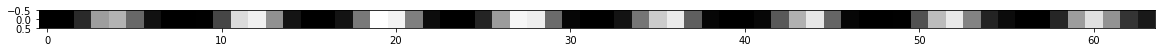

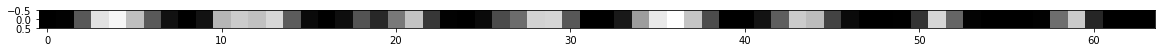

In [4]:
mask_ones     = (target == 1) 
mask_sevens   = (target == 7)
data_ones   = data[mask_ones,:]
data_sevens = data[mask_sevens,:]

data_avg_one   = np.average(data_ones, axis=0)
data_avg_seven = np.average(data_sevens, axis=0)

pixel_candidates =  np.argsort(-np.abs(data_avg_one-data_avg_seven))[:2]
print(pixel_candidates)

plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_one[None,:], interpolation="nearest")
plt.show()

plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_seven[None,:], interpolation="nearest")
plt.show()

So, the pixels with the flattened indices 19 and 60 are the two pixels with the largest differences between the two class averages. These linear indices corresponds to 2D indicies (3,2) and (4,7). We plot in 2d to confirm that our choice of pixels makes sense. 

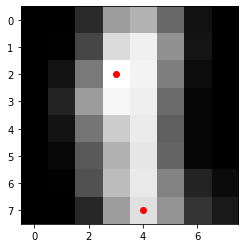

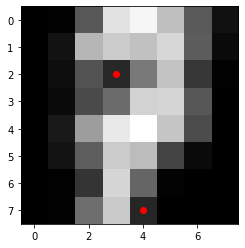

In [5]:
images_ones   = images[mask_ones,:,:]
images_sevens = images[mask_sevens,:,:]

img_avg_one   = np.average(images_ones, axis=0)
img_avg_seven = np.average(images_sevens, axis=0)

x = pixel_candidates % 8
y = pixel_candidates // 8

plt.figure()
plt.gray()
plt.imshow(img_avg_one, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

plt.figure()
plt.gray()
plt.imshow(img_avg_seven, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

Thus, we implement an function to reduce the number of dimensions from 64 to 2. This is done by only considering the pixel values in each of these two pixels for each instance. Effectivley, only these two feature dimensions are considered henceforth, all others are ignored.

In [6]:
def reduce_dim(x):
    return x[:,pixel_candidates]

### 3.2 - Scatterplot (4 pts)

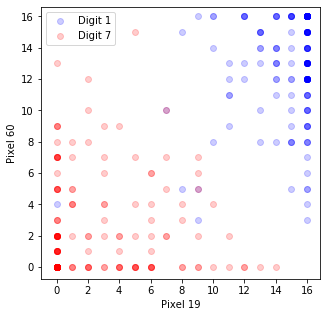

In [7]:
reduced_ones   = reduce_dim(data_ones)
reduced_sevens = reduce_dim(data_sevens)

plt.figure(figsize=(5,5))
plt.scatter(reduced_ones[:,0], reduced_ones[:,1], c="b", alpha=0.2, label='Digit 1')
plt.scatter(reduced_sevens[:,0], reduced_sevens[:,1], c="r", alpha=0.2,label='Digit 7')
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('Pixel 19')
plt.ylabel('Pixel 60')
plt.legend()
plt.show()

## 4 - Nearest Mean
### 4.1 - Implement the Nearest Mean Classifier (3 pts)
Find the mean of the 2D feature vectors of each class in the training set and assign the label of its nearest mean to test each test instance.

In [8]:
def nearest_mean(training_features, training_labels, test_features):
    """
    Implementation of the nearest mean classifier. The training features used as input 
    must be outputs from the reduce_dim() function.
    
    params
    ------
    training_features: np.array
        Matrix of shape (N,2), where N is the number of training instances.
    training_labels: np.array
        Matrix of shape (N,), where N is the number of training instances.
    test_features: np.array
        Matrix of shape (M,2), where M is the number of test instances. 

    returns
    -------
    np.array shape=(M,)
        Predicted labels for the test features, given the training set.
    """
    # Find all classes in the training set.
    unique_labels = np.unique(training_labels)

    # Calculate the 2D mean in feature space for each class independently.
    mu = np.zeros((unique_labels.shape[0], 2))
    for idx, label in enumerate(unique_labels):
        mu[idx] = np.average(training_features[training_labels == label], axis=0)

    # For each test instance, find the distances to all class means.
    dist = np.linalg.norm(test_features[:,None]-mu, axis=2)

    # Find the label of the closest class mean for each test instance.
    predicted_labels = unique_labels[np.argmin(dist, axis=1)]

    return predicted_labels

In [9]:
X_train_red = reduce_dim(X_train)
X_test_red  = reduce_dim(X_test)

predicted_labels = nearest_mean(X_train_red, y_train, X_test_red)

error_rate = np.sum(predicted_labels != y_test)/y_test.shape[0]
print(error_rate)

0.006896551724137931


### 4.2 - Visualize the decision regions (4 pts)

In [10]:
plt.contourf?

Signature: plt.contourf(*args, data=None, **kwargs)
Docstring:
Plot contours.

Call signature::

    contour([X, Y,] Z, [levels], **kwargs)

`.contour` and `.contourf` draw contour lines and filled contours,
respectively.  Except as noted, function signatures and return values
are the same for both versions.

Parameters
----------
X, Y : array-like, optional
    The coordinates of the values in *Z*.

    *X* and *Y* must both be 2-D with the same shape as *Z* (e.g.
    created via `numpy.meshgrid`), or they must both be 1-D such
    that ``len(X) == M`` is the number of columns in *Z* and
    ``len(Y) == N`` is the number of rows in *Z*.

    If not given, they are assumed to be integer indices, i.e.
    ``X = range(M)``, ``Y = range(N)``.

Z : array-like(N, M)
    The height values over which the contour is drawn.

levels : int or array-like, optional
    Determines the number and positions of the contour lines / regions.

    If an int *n*, use *n* data intervals; i.e. draw *n+1* con